# Summary

When we get all TSSs for 15 organs, we always want to get the cell-type specific TSS masked by gene expression.

Here, we mainly used t test to pick up these TSS.



# Content
* get gene list with alternative TSS in different cell type

* plot tsne example

## get gene list with alternative TSS in different cell type

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
from functools import reduce
import re
import matplotlib.pyplot as plt
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind
import os

In [4]:
def get_significant_gene(SRRID,certain_cell,organ):
    try:

        inputfile='/storage/yhhuang/users/ruiyan/15organ/scTSS_h5ad/two_transcript/'+SRRID+'.h5ad'
        print(inputfile)
        splicingadata=sc.read(inputfile)
        countdf=pd.DataFrame(splicingadata.obs['cluster'].value_counts())
        selectdf=countdf[countdf['cluster']>100]
        transcriptls=[]
        for geneid in splicingadata.var['gene_id'].unique():
            selectgeneadata=splicingadata[:,splicingadata.var['gene_id']==geneid]
            for i in selectgeneadata.var.index:
                i=selectgeneadata[:,selectgeneadata.var.index==i]
                specificCell=i[i.obs['cluster']==certain_cell,:]
                adatadict={}
                selectls=list(selectdf.index)
                #print(selectls)
                #print(certain_cell)
                selectls.remove(certain_cell)
                #print(selectls)

                for celltype in selectls:
                    adatadict[celltype]=i[i.obs['cluster']==celltype,:]
                pvaluels=[]
                differencels=[]
                cellclusterls=[]
                for cellcluster in adatadict.keys():
                    pvalue=ttest_ind(specificCell.X.reshape(-1,1),adatadict[cellcluster].X.reshape(-1,1))[1]
                    pvaluels.append(multipletests(pvalue,method='bonferroni')[1])

                    difference=np.mean(specificCell.X.reshape(-1,1))-np.mean(adatadict[cellcluster].X.reshape(-1,1))
                    differencels.append(difference)
                    cellclusterls.append(cellcluster)

                transcriptls.append([i.var.index.values,pvaluels,differencels,cellclusterls])



        transcriptdf=pd.DataFrame(transcriptls,columns=['transcript_id','p_value','difference','cellCluster'])
        transcriptdf['gene_id']=transcriptdf['transcript_id'].astype('str').str.split('_',expand=True)[0].str.split("'",expand=True)[1]


        keepls=[]
        for i in range(0,len(transcriptdf)):
            differencels=list(transcriptdf['difference'][i])
            if all(item>0 for item in differencels):
                keepls.append(transcriptdf['gene_id'][i])

        differencels=[]
        for geneID in keepls:
            selectgenedf=transcriptdf[transcriptdf['gene_id']==geneID]
            selectgenedf.reset_index(inplace=True)
            judgepValuels=[]
            for i in range(0,len(selectgenedf)):
                pvaluels=list(selectgenedf['p_value'][i])
                judgepValuels.append(all(item <0.01 for item in pvaluels))
            #print(judgepValuels)
            if  all(item==False for item in judgepValuels):
                pass
            elif all(item==True for item in judgepValuels):
                pass
            else:
                differencels.append(geneID)



        selectgene=set(differencels)

        genedf=transcriptdf[transcriptdf['gene_id'].isin(selectgene)]
        
        signtranscript=[]
        for i in genedf.index:
            pvaluels=list(genedf['p_value'][i])
            differencels=list(genedf['difference'][i])
            if (all(p<0.01 for p in pvaluels))&(all(diff>0 for diff in differencels)):
                signtranscript.append(genedf['transcript_id'][i])
                
        signtranscriptdf=pd.DataFrame(signtranscript,columns=['transcript_id'])
        signtranscriptdf['gene_id']=signtranscriptdf['transcript_id'].str.split('_',expand=True)[0]
        
        genedf=genedf[genedf['gene_id'].isin(signtranscriptdf['gene_id'])]
                
        
        
        
        
        



#         if certain_cell=='NK/T cell':
#             outputname='T_cell'

        outputname=re.sub('\s+|\/', '_', certain_cell)

        outputpath='/storage/yhhuang/users/ruiyan/15organ/sign_marker_fig_change/'+organ

        if os.path.exists(outputpath)==False:
            os.mkdir(outputpath)


        geneoutputfile=outputpath+'/'+outputname+'.csv'
        genedf.to_csv(geneoutputfile)
        
        transcriptoutputfile=outputpath+'/'+outputname+'_transcript.csv'
        signtranscriptdf.to_csv(transcriptoutputfile)
        
        

    except:
        print('hello')

        

In [ ]:
## get cell cluster


clusterls=[]

for i in range(18,33):
    file='SRR130757'+str(i)
    inputfile='/storage/yhhuang/users/ruiyan/15organ/scTSS_h5ad/two_transcript/'+file+'.h5ad'
    splicingadata=sc.read(inputfile)
    clusterls.append(splicingadata.obs['cluster'].unique().tolist())

In [ ]:
flattenls=[i for item in clusterls for i in item]
cellname=list(set(flattenls))
cellname

In [ ]:
organls=['bladder','blood','common_bile_duct','esophagus','heart','liver','lymph_node','marrow','muscle','rectum','skin','small_intestine','spleen','stomach','trachea']
srrls=['SRR130757'+str(i) for i in range(18,33)]
for i,srrid in zip(organls,srrls):
    for j in cellname:
        get_significant_gene(srrid,j,i)
        
        

## plot tsne example

In [5]:
import pandas as pd
import scanpy as sc

In [6]:
splicingadata=sc.read('/storage/yhhuang/users/ruiyan/15organ/scTSS_h5ad/two_transcript/SRR13075728.h5ad')
splicingadata

AnnData object with n_obs × n_vars = 7681 × 2114
    obs: 'cluster', 'tSNE1', 'tSNE2'
    var: 'TSS_start', 'TSS_end', 'gene_id', 'Chromosome', 'Feature', 'Start', 'End', 'Strand', 'gene_name', 'len', 'count'
    uns: 'log1p'
    obsm: 'X_tsne'

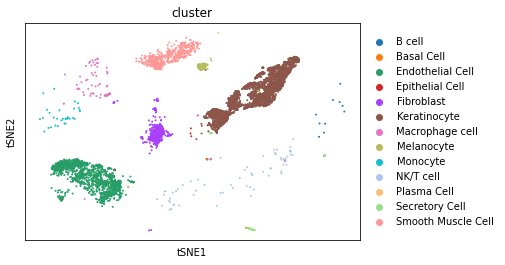

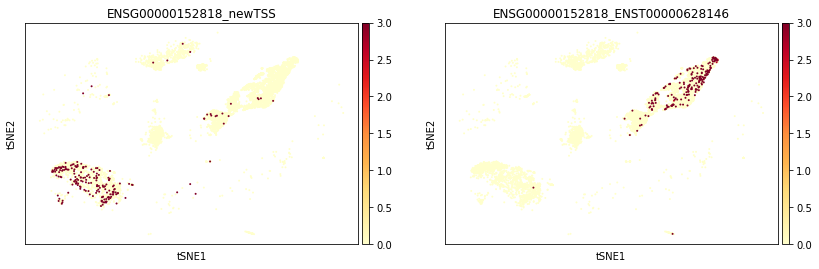

In [7]:
for i in ['ENSG00000152818']:
    try:
        #print(i)
        selectgenedf=splicingadata.var[splicingadata.var['gene_id']==i]
#         for i in range(0,len(selectgenedf.index)):
        #sc.pl.tsne(splicingadata,color=['cluster',selectgenedf.index[0],selectgenedf.index[1]],color_map='YlOrRd',vmin=0,vmax=3)
        sc.pl.tsne(splicingadata,color=['cluster'],color_map='YlOrRd',vmin=0,vmax=3,save='skin_cluster.pdf')
        sc.pl.tsne(splicingadata,color=[selectgenedf.index[0],selectgenedf.index[1]],color_map='YlOrRd',vmin=0,vmax=3,save='skin_transcript.pdf')
#         print(selectgenedf)
#         sc.pl.tsne(splicingadata,color=['cluster',selectgenedf.index[0],selectgenedf.index[1]],,color_map='YlOrRd',vmin=0,vmax=3)
    except IndexError:
        print('hello')


In [8]:
expressionadata=sc.read('/storage/yhhuang/users/ruiyan/15organ/SRR13075728/SRR13075728_transcription.h5ad')
expressionadata

AnnData object with n_obs × n_vars = 7681 × 33538
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'RNA_snn_res.orig', 'seurat_clusters', 'Color_of_tissues', 'Cell_type_in_each_tissue', 'tSNE_1', 'tSNE_2', 'Cell_type_in_merged_data', 'new_cluster'
    var: 'gene_ids', 'feature_types'
    uns: 'new_cluster_colors'
    obsm: 'X_tsne'

In [9]:
expressionadata.var.index=expressionadata.var['gene_ids']
expressionadata.var.index

Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241599', 'ENSG00000236601', 'ENSG00000284733',
       'ENSG00000235146',
       ...
       'ENSG00000277196', 'ENSG00000277630', 'ENSG00000278384',
       'ENSG00000278633', 'ENSG00000276345', 'ENSG00000277856',
       'ENSG00000275063', 'ENSG00000271254', 'ENSG00000277475',
       'ENSG00000268674'],
      dtype='object', name='gene_ids', length=33538)

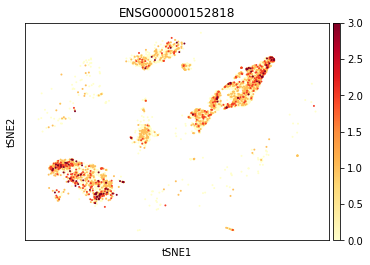

In [10]:
sc.pl.tsne(expressionadata,color=['ENSG00000152818'],color_map='YlOrRd',vmin=0,vmax=3,save='skin_expression.pdf')